# Lab assignment: getting explanations from ensemble models

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/madridAutomata.jpg">

<div style="float: right;">(MadriD: Automata, picture by <a href=https://www.deviantart.com/albarji/art/MadriD-Automata-721505521>Albarji</a>)</div>

In this assignment we will perform learn how to obtain explanations from ensemble models, that allows us the get some intuition of how the model is making its decisions. We will make use of the inspection methods available in scikit-learn, together with the explanations library <a href=https://github.com/slundberg/shap#citations>SHAP</a>.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
You will need to solve a question by writing your own code or answer in the cell immediately below or in a different file, as instructed.</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
This is a hint or useful observation that can help you solve this assignment. You should pay attention to these hints to better understand the assignment.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
This is an advanced exercise that can help you gain a deeper knowledge into the topic. Good luck!</font>

***

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Ensembles environment files](https://github.com/albarji/teaching-environments-ensembles).

The following code will embed any plots into the notebook instead of generating a new window:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Shift+Tab to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Data loading

For this exercise we will work the [Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset is made of 1994 census data of the United States of America. The objective of the dataset is to predict whether each individual earns more than 50K$/year, using demographic information. This dataset is readily available as part of the SHAP library, both in a form amenable for scikit-learn models and in its original form.

In [2]:
import shap
shap.initjs()

X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

Since we are going to test several model interpretation methods, let's add a random column to simulate a useless feature.

In [3]:
import numpy as np

rng = np.random.RandomState(seed=42)
X['Random Number'] = X_display['Random Number'] = rng.randn(X.shape[0])

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, X_display_train, X_display_test = train_test_split(X, y, X_display, test_size=0.2, random_state=7)

## Random Forest feature importance (Mean Decrease in Impurity)

Let's start with the interpretation methods already bundled in scikit-learn. Tree-based methods can compute the importance of each feature as the reduction in impurity they obtain when they are used in the tree. Similarly an ensemble of trees can estimate the imporance of a feature by computing the mean impurity decrease among trees.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Train a RandomForest model over the training data. You can use the default parameters. Name the trained model <b>rf</b>.
</font>

***

In [5]:
####### INSERT YOUR CODE HERE
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Let's check that the model is able to obtain reasonable accuracy on the train and test data.

In [6]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.859


Since we are not using any pruning strategies, most likely your model has overfitted the data. But we will nevertheless use this model and see how different inspection methods behave.

To obtain feature importances we can use the `feature_importances_` attribute of the model.

In [7]:
rf.feature_importances_

array([0.14754946, 0.03879286, 0.12387684, 0.05950139, 0.06672484,
       0.119539  , 0.0137025 , 0.01543988, 0.11193297, 0.03640763,
       0.08062961, 0.01669974, 0.16920329])

The importances are an array with the Mean Decrease in Impurity of each feature in the whole forest. For easier understanding we can create a barplot showing these importances.

FixedFormatter should only be used together with FixedLocator


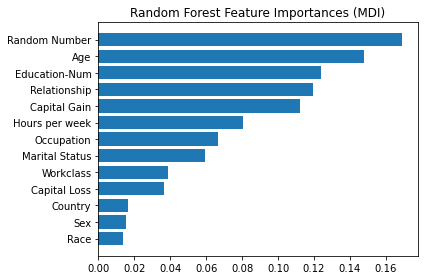

In [8]:
tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()

feature_names = X_train.columns
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

Note how the most important feature is *Random Number*, even though this is a useless feature! This is because this feature can perfectly split all the training datapoints, and thus produces the largest decrease in impurity. Basing our model in a random feature is clearly overfitting, but since the Mean Decrease in Impurity is computed over the data used in the model training, it is impossible to know this is a bad feature. That is the main reason why this method does not provide a good metric to assess feature relevance. Let's move on to a better approach!

## Permutation importances

A more suitable and general method to measuring relevances is Permutation Importances. To analyze the relevance of a feature, the column with the values of such feature is rearranged through a random permutation, and the loss in model performance is understood has the relevance of such feature. We can perform this analysis over the test data to obtain less biased interpretations. Also, the permutation can be repeated a number of times (*n_repeats*) to obtain more accurate relevance estimates.

In [9]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=8)
result

{'importances_mean': array([ 1.52771380e-02,  4.37586366e-03,  2.78059266e-02,  7.41593736e-03,
         9.84185475e-03,  3.07538769e-02, -1.38185168e-04, -8.90526639e-04,
         4.78734838e-02,  1.21602948e-02,  9.84185475e-03, -4.44089210e-17,
        -1.24366651e-03]),
 'importances_std': array([0.00219754, 0.00185934, 0.00242616, 0.00215398, 0.00183407,
        0.00182065, 0.00081376, 0.00130065, 0.00236948, 0.00108742,
        0.00195719, 0.0009662 , 0.0023741 ]),
 'importances': array([[ 0.01243667,  0.01596806,  0.01166897,  0.01750345,  0.01566099,
          0.0168893 ,  0.0133579 ,  0.01888531,  0.01627514,  0.01412559],
        [ 0.00414556,  0.00522033,  0.00138185,  0.00214955,  0.00660218,
          0.00475971,  0.0027637 ,  0.00337786,  0.00721634,  0.00614156],
        [ 0.02825119,  0.02686934,  0.02763703,  0.02901889,  0.02825119,
          0.02518041,  0.03178259,  0.02779057,  0.03055428,  0.02272378],
        [ 0.00429909,  0.00829111,  0.00660218,  0.0098265 ,  

Permutation Importances returns the estimated importance obtained for each feature and repetition (permutation), along with pooled means and standard deviations of importances for each feature. A good way to visualize these is by making use of boxplots:

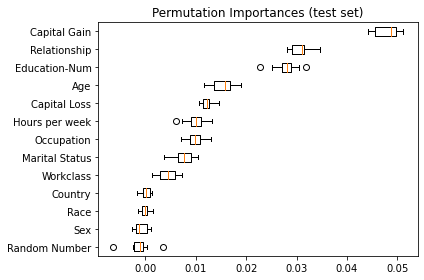

In [10]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

The Permutation Importance analysis reveals how the *Random Number* feature we introduced is not relevant at all, while other, more reasonable features such as *Capital Gain* are now very relevant.

## Partial dependence plots

A more fine-grained analysis of the influence of each feature on the target can be obtained through **partial dependence plots**. These plots show how changes along the value of each feature change the probability of predicting a positive class in the model. For instance, to compute this plot for the first feature in the data (*Age*) we just need to run

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


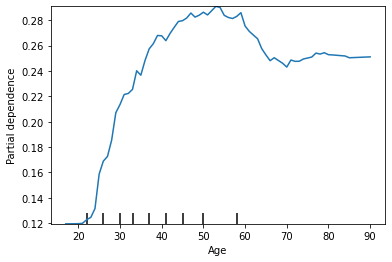

In [11]:
from sklearn.inspection import plot_partial_dependence

column = X_test.columns.get_loc('Age')
plot_partial_dependence(rf, X_test, features=[column])

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Generate partial dependences plot for the random feature we introduced, as well as for another relevant feature.</font>

***

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


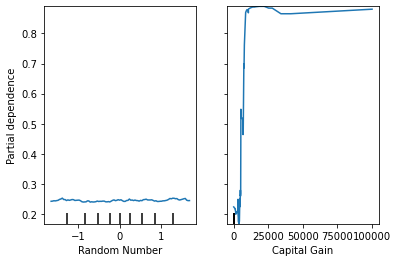

In [12]:
####### INSERT YOUR CODE HERE
plot_partial_dependence(rf, X_test, 
                        [X_test.columns.get_loc('Random Number'), X_test.columns.get_loc('Capital Gain')])

## SHAP local explanations

A non-obvious problem with the approaches above is that these explanation methods **do not have consistency** when trying to explain the relevance of each feature for an specific data point. Let's suppose we have two models: A and B. Model A has larger changes in its predictions than B if a certain feature $x_i$ is removed. However, if our explanation method is non-consistent, it might happen that the computed feature relevances show a larger relevance of feature $x_i$ in model B than in model A!

The SHAP library makes use of the [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) from game theory to guarantee consistency, among other useful properties such as local accuracy and missingness. It can also be shown mathematically that Shapely values are the only ones that meet all of these properties simultaneously.

SHAP integrates well with many ensemble method libraries. For instance, it can efficiently obtain accurate explanations for Extreme Gradient Boosting models.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
     Train an Extreme Gradient Boosting model over the training data. You can use the default parameters. Name the trained model <b>xgb</b>.

***

In [13]:
####### INSERT YOUR CODE HERE
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:14:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

The SHAP library includes several explaning methods for different kind of models. For an ensemble the **TreeExplainer** is the best choice.

In [14]:
explainer = shap.Explainer(xgb)

With this explainer we can obtain SHAP values for every feature in every data point, as follows:

In [15]:
explanation = explainer(X_test)
explanation

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


.values =
array([[ 1.62820771e-01,  8.16297159e-02, -1.43514872e-01, ...,
        -1.35096848e-01,  2.90966197e-03,  4.94309776e-02],
       [ 7.08788872e-01,  5.43795824e-01,  8.22433949e-01, ...,
         6.72141075e-01,  8.68327357e-03,  7.61718750e-02],
       [-2.34919572e+00, -1.89430304e-02, -2.41504586e-03, ...,
        -8.79036844e-01, -1.51961725e-02,  9.95396018e-01],
       ...,
       [-3.79294991e+00,  2.07003549e-01, -1.46421984e-01, ...,
        -1.17627251e+00, -3.29866149e-02, -2.50958242e-02],
       [-9.49600875e-01, -3.23766959e-03, -4.35684502e-01, ...,
        -1.98430568e-01, -1.00230211e-02,  2.56710768e-01],
       [ 5.21100700e-01,  4.34180535e-02,  9.30168256e-02, ...,
        -1.07157901e-01,  1.83489248e-02, -6.09170720e-02]], dtype=float32)

.base_values =
array([-1.451003, -1.451003, -1.451003, ..., -1.451003, -1.451003,
       -1.451003], dtype=float32)

.data =
array([[39.        ,  4.        , 10.        , ..., 40.        ,
        39.        ,  0.240

The returned object is of type `Explanation`, and contains three elements:
* The SHAP `values` for each data point
* The `base_values`, that is, the $\phi_0$ bias coefficient for each data point. This represents the model prediction when no features at all are used.
* The original `data` points we are explaining.

An `Explanation` can be indexed as if it were an array. So for instance, we can get the information about the first data point as

In [16]:
explanation[0]

.values =
array([ 0.16282077,  0.08162972, -0.14351487, -0.23867567,  0.66917014,
       -1.4635029 ,  0.01854988, -0.22606383, -0.12011684, -0.04636229,
       -0.13509685,  0.00290966,  0.04943098], dtype=float32)

.base_values =
-1.451003

.data =
array([3.90000000e+01, 4.00000000e+00, 1.00000000e+01, 0.00000000e+00,
       4.00000000e+00, 1.00000000e+00, 4.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.25000000e+02, 4.00000000e+01, 3.90000000e+01,
       2.40230626e-01])

These values must be interpreted as follows: by default the prediction of the model will be the `base_value`. However, after analyzing each of the values of the input features, this default prediction is impacted by each one the SHAP `values`. Positive SHAP values mean the corresponding feature increases the probability of predicting positive class, while negative values reduce this probability. This can be visualized with a force plot:

In [17]:
shap.plots.force(explanation[0])

The plot shows as `base value` the default value predicted by the model, and as <font color="red">red</font> and <font color="blue">blue</font> the features that increase or decrease the output value. The final **output value** shown in bold is the prediction made by the model after considering all the features. This representation is useful to understand why the model decided to produce its classification.

Alternatively, we can also use a waterfall plot to represent the same information

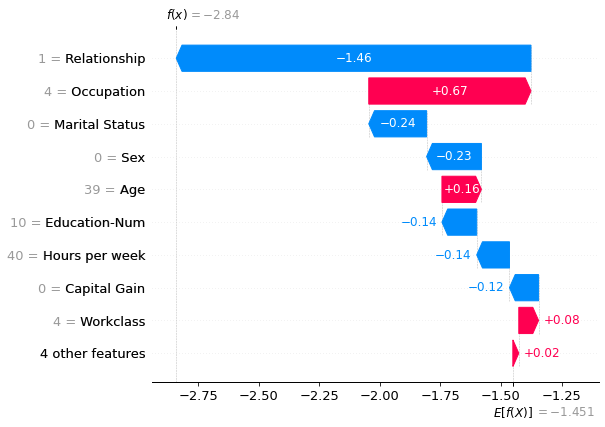

In [18]:
shap.plots.waterfall(explanation[0])

## SHAP feature relevances

By grouping all the computed SHAP values by features and drawing a scatterplot we can visualize the global relevance of each feature in the model:

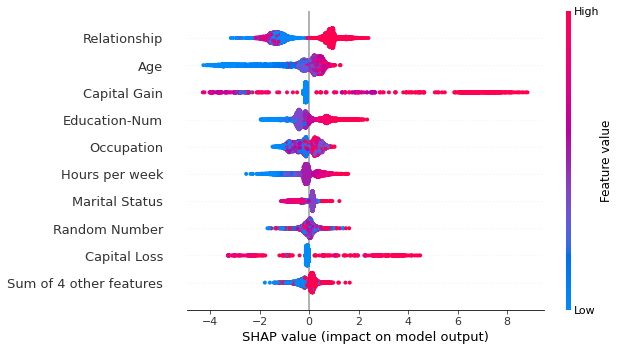

In [19]:
shap.plots.beeswarm(explanation)

## SHAP dependence plots

We can also obtain partial dependence plots from SHAP values. For instance, we can plot again how the *Age* influences the probabilities of high-earnings

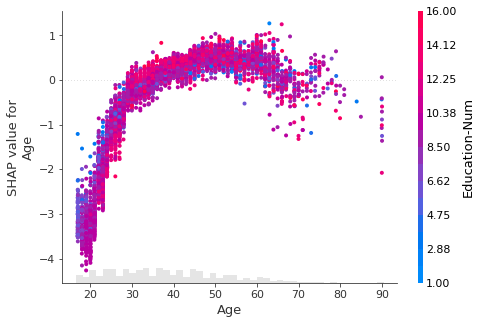

In [23]:
shap.plots.scatter(explanation[:,"Age"], color=explanation)

The plot shows a scatterplot with a dot for each datapoint in the test set, organized by their *Age* and corresponding SHAP value. To make the plot easier to understand, SHAP automatically selects another highly discriminative feature and uses it to color the dots. This provides more information than a scikit-learn partial dependence plot.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
     Generate SHAP partial dependences plot for the random feature we introduced, as well as for the other relevant feature you plotted in the partial dependencies exercise above. Can you spot differences between scikit-learn and SHAP plots?

***

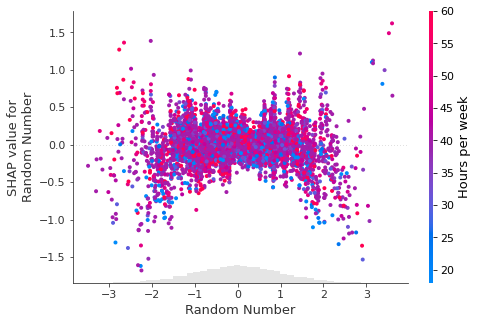

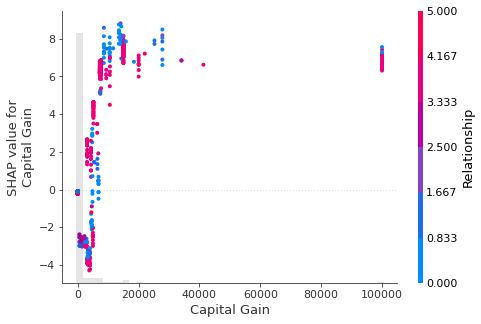

In [24]:
####### INSERT YOUR CODE HERE
shap.plots.scatter(explanation[:,"Random Number"], color=explanation)
shap.plots.scatter(explanation[:,"Capital Gain"], color=explanation)